## Hybrid Retrieval and Agent Integration - PoC - 2
Here, we will integrate the hybrid search retrieval mechanism with the Modified Data-Analyst agent.

The new mechanism will cater to the isolated-context problem.

Let's get started.

In [1]:
import os
import io
import sys
import json
import traceback
import regex as re
import pandas as pd
from pyjstat import pyjstat
from textwrap import dedent
from pyjstat import pyjstat
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Dict, List, Any, Literal, Annotated

from langgraph.types import Command
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, AIMessage, ToolMessage
from langgraph.prebuilt import InjectedState
from langchain_core.tools import tool, InjectedToolCallId

In [ ]:
from pathlib import Path
import os

root = Path().absolute().parents[1]
os.chdir(str(root))

from src.storage.json_stat_archive_db import JSONStatArchiveDB

In [3]:
llm_low = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_med = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_high  = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [24]:
def _run_python_safely(code: str) -> Dict[str, Any]:
    """
    Minimal sandbox runner. In production: isolate with subprocess, container, time & mem limits.
    Returns {"stdout": str, "error": {"type":, "message":, "trace":}} on failure.
    """
    stdout_capture = io.StringIO()
    old_stdout, old_stderr = sys.stdout, sys.stderr
    sys.stdout = stdout_capture
    sys.stderr = stdout_capture  # co-mingle
    globals_dict = {"__name__": "__main__"}
    try:
        exec(code, globals_dict, globals_dict)
        out = stdout_capture.getvalue()
        return {"stdout": out}
    except Exception as e:
        err = {"type": e.__class__.__name__, "message": str(e), "trace": traceback.format_exc()}
        return {"stdout": stdout_capture.getvalue(), "error": err}
    finally:
        sys.stdout, sys.stderr = old_stdout, old_stderr

@tool(name_or_callable="python_code_executor", parse_docstring=True)
def python_code_executor(
    code: str,
    description: str,
    # state: Annotated[dict, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """
    Executes the given Python code and returns the output.
    
    Args:
        code (str): The Python code to execute.
        description (str): A short description of the code being executed.
    
    Returns:
        str: The output of the executed code.
    """
    print("Executing code in python_code_executor: ", description, "\n", code)
    result = _run_python_safely(code)

    if 'error' in result:
        print("Result from python_code_executor: ", result['error'])
        return Command(
            update={
                "scratchpad": [
                    ToolMessage(
                        content=f"Error executing code: {result['error']}",
                        tool_call_id=tool_call_id,
                        name="python_code_executor"
                    )
                ],
            }
        )
    
    print("Result from python_code_executor: ", result['stdout'])
    return Command(
        update={
            "scratchpad": [
                ToolMessage(
                    content=result['stdout'],
                    tool_call_id=tool_call_id,
                    name="python_code_executor"
                )
            ],
        }
    )

TOOLS = [python_code_executor]

llm_med_with_code_exec_tool = llm_med.bind_tools(TOOLS, allowed_function_names=["python_code_executor"])
llm_high_with_code_exec_tool = llm_high.bind_tools(TOOLS, allowed_function_names=["python_code_executor"])

In [25]:
class State(TypedDict):
    """State for the analyst agent."""
    scratchpad: Annotated[list[BaseMessage], add_messages] = Field(default=[], description="The scratchpad for the agent.")
    table_id: str = Field(description="The ID of the table being queried.")
    question: str = Field(description="The question asked by the user.")
    analysis_plan: str = Field(description="The rough analysis plan for the agent to follow.")
    context: str = Field(default=None, description="The context for the agent to use.")
    iters: int = Field(default=0, description="The number of iterations the agent has gone through.")


In [26]:

cso_archive_reader = JSONStatArchiveDB(compression_level=12)

In [27]:
SYSTEM_PROMPT_ANALYST = dedent(
    f"""\
        # ROLE: I am a Data Analyst Agent that has access to Python-shell tool/function - `python_code_executor(code: str, description: str)`.

        # INSTRUCTIONS:
            - I call the `python_code_executor` tool to analyse the data.
            - Once I feel I know enough, I give a crisp and concise answer to the user's question.

        # NOTE:
            - The python-script should import necessary libraries (pandas, numpy, os, pathlib, etc) to read the CSV file and perform data manipulation 
            - The python-script use `print` statements for printing any statistics that you need to fetch.
            - In a single tool-call to `python_code_executor`, I ask for a single statistic to be fetched.
            - I keep the commentary limited in this step.
            - Once I have enough statistics to answer the user's question, I give a crisp and concise answer to user's question, with proper data backing it up.
        
        # WARNINGS:
            - For tool-calls to `python_code_executor` tool, only send the python code as `code` parameter
            - Do not include any visualizations or plots in the code.
            - In case I get reported back with any errors in executing the python code, I should make necessary corrections and call the python_code_executor tool to re-run the code.
            - The "Analysis-Plan" provided to me is a rough plan, I should adapt it as per the data available in the table.
        
        # TIPS:
            - For high cardinality columns, consider using simple keyword based filtering (like `str.contains('abc|xyz')`). Also consider items / categories related to said keywords.
    """
)

def analyst_agent(state: State) -> str:
    """
    The analyst agent has access to the Python-Shell tool and uses it answer the user query by analysing the data available in context.

    Args:
        state (State): The state containing the messages and other data.
    
    Returns:
        str: The response from the analyst agent.
    """
    table_id = state["table_id"]
    question = state["question"]
    analysis_plan = state["analysis_plan"]
    context = state["context"]
    old_messages = state["scratchpad"]

    system_prompt = SYSTEM_PROMPT_ANALYST
    iters = state.get("iters", 0)
    iters += 1

    context = f"CONTEXT:\n{context}\n\nANALYSIS PLAN:\n{analysis_plan}"
    msgs = [
        SystemMessage(content=system_prompt, name="analyst_agent"),
        SystemMessage(content=context, name="analyst_agent"),
        HumanMessage(content=question, name="analyst_agent"),
    ] + old_messages
    
    if iters <= 10:
        print("Running data-analyst agent...")
        res = llm_med_with_code_exec_tool.invoke(msgs)
    else:
        print("Stopping tool-calls as max-iterations reached. Generating final response...")
        res = llm_med.invoke(msgs)
        return {"scratchpad": [res], "iters": iters, "context": context}
    
    if isinstance(res, AIMessage):
        return {"scratchpad": [res], "iters": iters, "context": context}
    else:
        res = AIMessage("Error generating code.")
        return {"scratchpad": [res], "iters": iters, "context": context}


In [28]:
def has_tool_calls(msg: AIMessage) -> bool:
    """
    Check if the AIMessage has tool calls.
    
    Args:
        msg (AIMessage): The AI message to check.
    
    Returns:
        bool: True if the message has tool calls, False otherwise.
    """
    return getattr(msg, "tool_calls", None) is not None or \
           bool(getattr(msg, "additional_kwargs", {}).get("function_call") or \
                getattr(msg, "additional_kwargs", {}).get("tool_calls"))


def custom_tools_condition(state: State) -> bool:
    """
    Route the LLM based on tool calls in the last message.
    
    Args:
        state (State): The current state of the graph.
    
    Returns:
        str: "tools" if the last message has tool calls, "end" otherwise.
    """
    messages_key = "scratchpad"
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

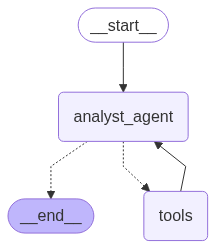

In [29]:
tool_node = ToolNode(TOOLS, messages_key="scratchpad")

analyst_graph_builder = StateGraph(State)

analyst_graph_builder.add_node("analyst_agent", analyst_agent)
analyst_graph_builder.add_node("tools", tool_node)

analyst_graph_builder.add_edge(START, "analyst_agent")
analyst_graph_builder.add_conditional_edges("analyst_agent", custom_tools_condition, {"__end__": END, "tools": "tools"})
analyst_graph_builder.add_edge("tools", "analyst_agent")

analyst_graph = analyst_graph_builder.compile()
analyst_graph

## Fixing context-isolation problem

state:
    - messages: List[str]
    - relevant_docs: List[Dict]
        - table_id: str
        - context: str
        - analysis_plan: str
    - question: str
    - iter: int
         
reviewer-agent
    - has access to data-cso hybrid-retrieval tool - given a user prompt, it may choose to call this hybrid-retrieval tool. This tool updates the `relevant_docs` in state, and also returns a ToolMessage containing all context for all tables it retrieved [CHANGE: I've integrated the planner part in this tool itself, so no 2 separate tools now...]
    - [OBSELETE; ignore] it also has access to the planner tool, which is basically an agent. it takes in the `messages`, creates a low-level plan for each data-source analysis and updates the `relevant_docs` with the plan. Also it returns a ToolMessage containing the plan for all tables
    - finally, it has access to the data-analyst subgraph as a tool. It can make multiple tool-calls to this tool. The tool node containing this subgraph will call the subgraph with the `table_id`, `question`, `analysis_plan`, and the `context`.

Giving this level of autonomy may have the following effect:
- Pros: context-isolation problem may be fixed
- Cons: redundant recursive loops, uncertainty in making tool-calls / malformed tool-calls, hallucinations, or even premature answering

In [30]:
# LLM Structured Output Models
class AnalysisPlanSubModel(BaseModel):
    table_id: str = Field(description="The ID of the relevant table.")
    analysis_plan: List[str] = Field(description="The low-level analysis plan for the table. Contains a list of steps.")

class AnalysisPlanModel(BaseModel):
    plans: List[AnalysisPlanSubModel] = Field(description="List of analysis plans for relevant tables.")


# Graph State Models
class RelevantTablesModel(BaseModel):
    table_id: str = Field(description="The ID of the relevant table.")
    context: str = Field(description="The statistical data profile of the table.")
    analysis_plan: List[str] = Field(description="The low-level analysis plan for the table. Contains a list of steps.")


class ParentState(TypedDict):
    """State for the parent graph."""
    messages: Annotated[list[BaseMessage], add_messages] = Field(default=[], description="The messages for the parent graph.")
    question: str = Field(description="The question asked by the user.")
    iter: int = Field(default=0, description="The iteration count for the current state.")
    relevant_tables_ids: List[RelevantTablesModel] = Field(default=[], description="List of relevant table IDs, their contexts, and analysis plans.")

In [ ]:
from src.retrieval.hybrid_retrieval import HybridRetrieval


retriever = HybridRetrieval(top_k_stage_1=200, top_k_stage_2=20)


def _create_table_analysis(df: pd.DataFrame, table_id: str) -> dict:
    """
    Analyzes the table and returns a dictionary with the analysis results.

    Args:
        df (pd.DataFrame): The DataFrame containing the CSO data.

    Returns:
        dict: A dictionary containing the analysis results.
    """
    csv_fp = f"cache/{table_id}.csv"
    try:
        table_shape = df.shape
        table_sample = pd.concat([df.head(5), df.tail(5)]) if len(df) > 10 else df
        
        table_info_df = pd.DataFrame({
            "columns": df.columns,
            "dtypes": [str(df[col].dtype) for col in df.columns],
            "nunique": [df[col].nunique() if df[col].nunique() <= 50 else '>50' for col in df.columns],
            "nulls": [df[col].isnull().sum() for col in df.columns]
        })

        context_list = [
            f"**Table ID:** {table_id}",
            f"- **CSV File Path**: {csv_fp}",
            f"- **Table Shape**: {table_shape}",
            "- **Table Info**:",
            table_info_df.to_string(index=False),
            "- **Table Sample (first and last 5 rows)**:",
            table_sample.to_string(index=False),
        ]

    except Exception as e:
        context_list = None

    return context_list

@tool("data_analyst_tool", parse_docstring=True)
def data_analyst_tool(
    table_id: str,
    # question: str,
    state: Annotated[dict, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
):
    """
    Tool to invoke the data analyst agent and return the final analysis.
    
    Args:
        table_id (str): The ID of the table to analyze.
        state (dict): The current state of the conversation.
        tool_call_id (str): The ID of the tool call.

    Returns:
        Command: The command to update the chat with the data analyst's response.
    """
    question = state["question"]
    relevant_tables_metadata = state["relevant_tables_ids"]

    for relevant_table_metadata in relevant_tables_metadata:
        if relevant_table_metadata["table_id"] == table_id:
            analysis_plan = "\n".join(relevant_table_metadata["analysis_plan"])
            context = relevant_table_metadata["context"]
            break


    print("DATA_ANALYST_TOOL: Invoking data analyst tool...")
    res = analyst_graph.invoke({"table_id": table_id, "question": question, "context": context, "analysis_plan": analysis_plan})
    last_message = res["scratchpad"][-1]
    print("DATA_ANALYST_TOOL: Run Successfully", last_message.content)
    return Command(
        update={
            "messages": [
                ToolMessage(
                    content=last_message.content,
                    tool_call_id=tool_call_id,
                    name="data_analyst_tool",
                )
            ]
        }
    )

@tool("hybrid_retrieval_tool", parse_docstring=True)
def hybrid_retrieval_tool(
    user_prompt: str,
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """
    Tool to invoke the hybrid retrieval and return relevant table IDs.
    
    Args:
        user_prompt (str): The user's question or prompt.

    Returns:
        Command: The command to update the chat with the relevant table IDs.
    """
    print("HYBRID_RETRIEVAL_TOOL: Invoking hybrid retrieval tool...")
    relevant_tables_ids = retriever.search(query=user_prompt)
    print(f"HYBRID_RETRIEVAL_TOOL: LLM selected {len(relevant_tables_ids)} relevant tables.")

    if not relevant_tables_ids:
        print("HYBRID_RETRIEVAL_TOOL: No relevant tables found.")
        return Command(
            update={
                "messages": [
                    AIMessage(content="No relevant tables found.")
                ]
            }
        )
    else:
        print(f"HYBRID_RETRIEVAL_TOOL: Found {len(relevant_tables_ids)} relevant tables.")

        csv_save_dir = "cache/"
        relevant_tables_metadata = []
        table_contexts_list = []
        contexts_dict = {}

        for table_id in relevant_tables_ids:
            csv_fp = csv_save_dir + f"{table_id}.csv"

            # check if "<table_id>.csv" exists. If not, read the pyjstat-file from artifacts and save the DataFrame as "<table_id>.csv"
            if not os.path.exists(csv_fp):
                for _, ds, _ in cso_archive_reader.read("artifacts/cso_bkp/cso_archive/jsonstat_archive.sqlite", table_id=table_id, with_labels=True):
                    df: pd.DataFrame = pyjstat.from_json_stat(ds)[0]
                df.to_csv(csv_fp, index=False)
            else:
                df = pd.read_csv(csv_fp)
            
            context_list = _create_table_analysis(df, table_id)
            context = "\n".join(context_list) if context_list else "No context available."
            table_contexts_list.append(context)
            contexts_dict[table_id] = context
            
        table_contexts = "\n\n".join(table_contexts_list)
        system_message_list = [
            "# GOAL: I am a Planner agent. Given a user-query and the relevant tables in context, I need to create a low-level plan for the data-analyst agent to carry out its analysis step-by-step to achieve the desired outcome.",
            "",
            "# CONTEXT:",
            table_contexts,
        ]
        system_message = "\n".join(system_message_list)

        res = llm_med.with_structured_output(AnalysisPlanModel).invoke(
            [
                SystemMessage(content=system_message, name="planner_agent"),
                HumanMessage(content=user_prompt, name="user")
            ]
        )
        res_dict = res.model_dump()
        plans_list = res_dict["plans"]
        for table_plan in plans_list:
            table_id = table_plan["table_id"]
            analysis_plan = table_plan["analysis_plan"]

            relevant_tables_metadata.append(
                {
                    "table_id": table_id,
                    "context": contexts_dict.get(table_id, ""),
                    "analysis_plan": analysis_plan
                }
            )

        tool_message_list = []
        for relevant_table_metadata in relevant_tables_metadata:
            tool_message_list.append(f"Table ID: {relevant_table_metadata['table_id']}")
            tool_message_list.append(f"Context: {relevant_table_metadata['context']}")
            tool_message_list.append(f"Analysis Plan: {relevant_table_metadata['analysis_plan']}")
            tool_message_list.append("")

        tool_message = "\n".join(tool_message_list)

        return Command(
            update={
                "relevant_tables_ids": relevant_tables_metadata,
                "messages": [
                    ToolMessage(
                        content=tool_message,
                        tool_call_id=tool_call_id,
                        name="relevant_tables_metadata"
                    )
                ]
            }
        )

NEW_TOOLS = [hybrid_retrieval_tool, data_analyst_tool]
llm_med_with_tools_poc = llm_med.bind_tools(NEW_TOOLS)

In [50]:
reviewer_system_prompt = dedent(
    """\
        # GOAL: I'm a helpful assistant. My job is to answer the user-question using all the facts available.

        # INSTRUCTIONS:
            - I have the following tools available for my tasks:
                1. hybrid_retrieval_tool: To retrieve relevant table IDs from CSO-DATA based on user queries.
                2. data_analyst_tool: To run the analysis on the retrieved tables.
            - Once I have the relevant data from tables, I will use the data_analyst_tool to perform the analysis.
            - Once I have the results from the analysis, I will answer the user's question in detail, using only the insights gained from the analysis.
            - I will cite the sources of my information (table-IDs) against each fact.

        # RETURN FORMAT:
            - The final answer containing text / tables should be in Markdown format
    """
)

def reviewer_agent(state: ParentState):
    old_messages = state["messages"]
    question = state["question"]
    iter = state.get("iter", 0) + 1

    msgs = [
        SystemMessage(content=reviewer_system_prompt, name="reviewer_agent"),
        HumanMessage(content=question, name="user")
    ] + old_messages
    res = llm_med_with_tools_poc.invoke(msgs)
    if iter > 12:
        return {"messages": [AIMessage("Max iterations reached, ending...")], "iter": iter}

    return {"messages": [res], "iter": iter}

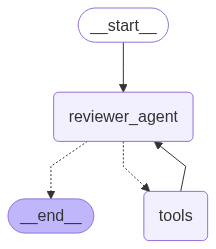

In [51]:
new_tool_node = ToolNode(NEW_TOOLS)

new_graph_builder = StateGraph(ParentState)

new_graph_builder.add_node("reviewer_agent", reviewer_agent)
new_graph_builder.add_node("tools", new_tool_node)

new_graph_builder.add_edge(START, "reviewer_agent")
new_graph_builder.add_conditional_edges("reviewer_agent", tools_condition)
new_graph_builder.add_edge("tools", "reviewer_agent")

app = new_graph_builder.compile()
app

In [61]:
question = "QUESTION: Give me the breakdown of renewable energy resources as a percentage share and absolute numbers in 2022 in ireland."
question = "QUESTION: How's the energy production in ireland over the years? Do a detailed comparison of renewable vs non-renewable share of energy"
# question = "QUESTION: How's the wind energy production over the years?"
question = "QUESTION: Did the Ukraine war have any impact on the energy production in ireland??"
# question = "QUESTION: How has nuclear energy done over the years in ireland?"
# question = "QUESTION: What's the impact of climate change on energy production in ireland?"
# question = "QUESTION: How's the energy production in ireland over 2021-2025? Do a detailed comparison of renewable vs non-renewable share of energy"
# question = "QUESTION: What's the total agricultural area in Ireland? Answer in detail."
# question = "detailed statistics on cosmetics, toileteries and related items production in prodcom data for ireland"
# question = "detailed statistics on lignin based products and related items production in prodcom data for ireland"
# question = "Population growth in ireland over the last 2 decades?"
question = "What are the production volume and value for agriculture sector. Within the agriculture sector, what is the share of different sector w.r.t volume and value."

res = app.invoke({"question": question})

HYBRID_RETRIEVAL_TOOL: Invoking hybrid retrieval tool...


HYBRID_RETRIEVAL_TOOL: LLM selected 3 relevant tables.
HYBRID_RETRIEVAL_TOOL: Found 3 relevant tables.
DATA_ANALYST_TOOL: Invoking data analyst tool...
Running data-analyst agent...
Executing code in python_code_executor:  Calculate the total production volume for the agriculture sector over time. 
 
import pandas as pd

df = pd.read_csv('cache/ASEA1.csv')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

volume_df = df[(df['Statistic'] == 'Estimated Quantity of Agricultural Output') & (df['Product'] == 'Total Agriculture')].copy()
volume_df.dropna(subset=['value'], inplace=True)

total_volume = volume_df.groupby('Year')['value'].sum().reset_index()
print(total_volume.to_string())

Result from python_code_executor:  Empty DataFrame
Columns: [Year, value]
Index: []

Running data-analyst agent...
Executing code in python_code_executor:  Calculate the total estimated value of agricultural output for each year. 
 import pandas as pd

df = pd.read_csv('cache/ASEA1.csv')
df['Year'] = 

In [62]:
res

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'hybrid_retrieval_tool', 'arguments': '{"user_prompt": "production volume and value for agriculture sector and share of different sector within agriculture w.r.t volume and value"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--c064009d-be69-4d61-9246-9cda0946c555-0', tool_calls=[{'name': 'hybrid_retrieval_tool', 'args': {'user_prompt': 'production volume and value for agriculture sector and share of different sector within agriculture w.r.t volume and value'}, 'id': '3d8c7755-46a4-4397-aaba-7f55309e760e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 341, 'output_tokens': 215, 'total_tokens': 556, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 173}}),
  ToolMessage(content='Table ID: ASEA1\nContext: **Table ID:** ASEA1\n- **CSV File Path

In [63]:
print(res["messages"][-1].content)

The agriculture sector's estimated total output value fluctuated between approximately 12.6 billion and 14.6 billion from 1990 to 2003, peaking at 14667.4 million in 1995 and reaching its lowest in 2003 at 12611.2 million. The total estimated quantity of agricultural output (volume) varied from approximately 68.7 billion to 80.6 billion, with the highest volume in 1999 (80635.0 units) and the lowest in 1996 (68719.0 units) (Table ID: ASEA1).

**Share of Different Sectors within Agriculture:**

**By Value (Table ID: ASEA1):**
*   **Goods Output at Producer Prices** consistently held the largest share, generally exceeding 34% of the total agricultural value.
*   **Total Livestock (Incl. Stock Changes)** contributed between 15% and 17%.
*   **Milk (m litres)** represented approximately 9.7% to 11.4%.
*   **Total Cattle** accounted for 8.7% to 12.4%.
*   **Crops** typically contributed between 6.7% and 9.3%.
*   Products such as **Oats, Turf, Mushrooms, and Sugar Beet** generally made up l

In [40]:
question_follow_up = "Ok, can you mention all the categories you used for your analysis that you found in the prodcom tables?"

res_follow_up = llm_med.invoke(
    [
        SystemMessage(content="You are a helpful assistant", name="reviewer_agent"),
        HumanMessage(content=question_follow_up, name="user"),
    ] + res["messages"] + [HumanMessage(content=question_follow_up)]
)

In [41]:
print(res_follow_up.content)

Based on the analysis plans used for the Prodcom tables (PCA23, PCA22, and PCA18), I filtered the `Product` column using the following keywords to identify relevant categories:

*   **cosmetic**
*   **toilet**
*   **perfume**
*   **soap**
*   **shampoo**
*   **make-up**
*   **fragrance**
*   **personal care**
*   **dentifrice**
*   **oral hygiene**

These keywords were used to capture a broad range of products related to cosmetics, toiletries, and personal care.
